# Intro to Narrow-band Doppler Drifting Signals in Spectrograms

In [8]:
# Perform some prelimiary Julia setup
# This may take some time the very first time it runs
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots
using FFTW
default(legend=false)

  Activating project at `~/JuliaDeDopplerNotebooks`


## Doppler drifting signals

Signals whose frequencies change linearly over time are referred to as *Doppler
drifting signals*.  Doppler drift, caused by a relative acceleration between
transmitter and receiver, should not be confused with the stochastic drift in
frequency exhibited by an unlocked oscillator.

Doppler drifing narrow-band signals appear in a frequency-time spectrogram as
diagonal lines.

## Spectrograms

A frequency-time spectrogram consists of a series of power spectra that are
sequential in time.  They are often plotted in a two dimensional "heatmap" where
one dimension is frequency, the other dimension is time, and the color or gray
scale of each point correponds to the power at that point.  These plots are
sometimes referred to as a *waterfall plots*.

Here we define a few parameters of a frequency-time spectrogram:

- $N_f$ is the number of frequency channels
- $N_t$ is the number of spectra (aka *time samples*)
- $\delta_f$ is the frequency step between successive frequency channels
- $\delta_t$ is the time step between successive spectra
- $\Delta_f$ is a difference between two frequencies
- $\Delta_t$ is a difference between two times
- $\Delta_{t_i}$ is the time ofset of the $i$-th spectrum relative to the first spectrum


## Doppler drift rate

Doppler drift rate, $R$, is defined as a change in frequency over a change in time:

$$
\begin{equation*}
R = \frac{\Delta_f}{\Delta_t}, \qquad
\Delta_f = R \Delta_t, \qquad
\Delta_t = \frac{R}{\Delta_f},
\end{equation*}
$$

## Doppler drift rate search

To search for Doppler drifting narrow-band signals of a given drift rate, $R$,
one can shift successive spectra in frequency by $\Delta_f$ determined by $R$
and the $\Delta_{t_i}$ of each spectrum.  This aligns the signal in frequency
over all the spectra.  Summing (aka *integrating*) over time will produce a
single integrted spectrum with all of the signal's power added together in the
channel or channels that the signal spans.  Signals with other drift rates will
not have the same benefit so their power will be spread across a wider frequency
range.  Narrow peaks in the integrated spectrum are indicative of a signal
drifting at rate $R$.  This process can be repeated for multiple drift rates
depending on the desired search parameters.

## Frequency shifting

Because a power spectrum is already in the *frequency domain*, shifting a power
spectrum in frequency is equivalent to shifting any sequence of samples.
Shifting by an integer number of samples is simply a reordering of the sequence,
but shifting by non-integer amounts is more complicated.  One way to shift by a
fractional number of samples is to convolve the input signal with a suitably
shifted Driac's delta function.  This may appear to suffer from the same
complications as before regarding non-integer shifts, but because convolutions
can be (and usually are) computed via multiplication in the Fourier domain, we
never have to actually materialize the fractionaly shifted delta function in the
input domain because we can driectly compute its Fourier transform analytically.
Using this technique, a non-integer shift on the input sequence can be performed
by:

1. Computing the DFT of the input samples
2. Multiplying the resulting Fourier domain values by the DFT of a shifted delta
   function
3. Computing the inverse DFT back to the input domain

The Fourier transform of a shifted Dirac's delta function is a complex
exponential whose frequency is proportional to the shift.  This complex sinusoid
is often called a *phasor* or sometimes a *phase slope* because a plot of the
phase is a sloping line.

Consider an input sequence $x$ of length N, where $n \in 0, 1, ..., N-1$.  The
DFT of this sequence is computed (usually using the FFT algorithm) as:

$$
\begin{equation}
X_k = \sum_{n=0}^{N-1} x_n e^{-j\frac{2\pi nk}{N}}
\end{equation}
$$

If we wish to shift $x$ by $s$ samples, the phasor $\theta$ that we
need to multiply $X$ by, element-wise, is:

$$
\begin{equation}
\theta_k = e^{-j\frac{2\pi ks}{N}}
\end{equation}
$$

Let's make a simple input sequence:

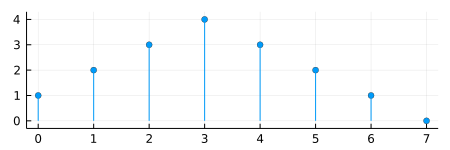

In [2]:
x = [1, 2, 3, 4, 3, 2, 1, 0]
N = length(x)
sticks(0:7, x, marker=true, xticks=0:7, size=(450,150), ylim=(-0.3,4.3))

Now we use `fft` to take the FFT, then plot the amplitude and phase:

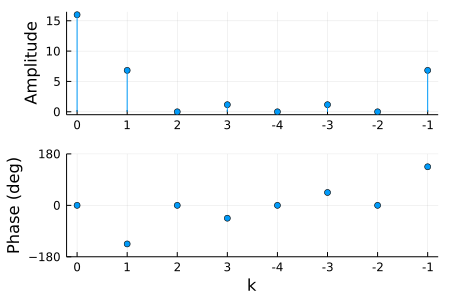

In [3]:
X = fft(x)
k = fftfreq(N,N)
let # Use `let` block to avoid polluting global namespace
    # Plot amplitude
    amp = sticks(abs.(X),
        ylabel="Amplitude",
        xticks=(1:N, Int.(k)),
        marker=true,
        size=(450,150)
    )
    # Plot phase
    phase = scatter(rad2deg.(angle.(X)),
        xlabel="k",
        ylabel="Phase (deg)",
        xticks=(1:N, Int.(k)),
        yticks=(-180:180:180),
        ylim=(-180,180),
        size=(450,150)
    )
    # Combine as subplots
    plot(amp, phase, layout=(2,1), size=(450,300))
end

Notice the ordering of the $k$ index.  This is the order that the `fft` function
returns the frequency channels.  We could use `fftshift` to reorder the samples
to range from -4 to +3, but that function copies data rather than creating a
lightweight "view".  We can avoid this extra memory churn by just being aware of
this ordering of the $k$ index.

Now it is time to compute the phasor $\theta$.  We will write this as a function
of $k$, $s$, and $N$ that computes a single complex exponenial value.  We can
broadcast this function over $k$ to compute values for all elements of $X$.
Normally we would also broadcast the multiplication of $X$ by the $\theta$
values so that the Vector of $\theta$ values need not be allocated, but for this
notebook we will create it as a separate Vector so that we can plot it.  Here we
are using a shift of 0.5 samples.

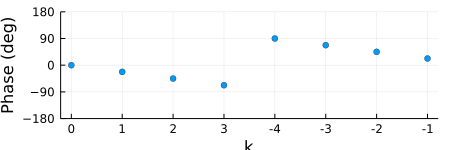

In [4]:
function phasor(k,s,N)
    exp(-2im*π*k*s/N)
end

θ05 = phasor.(k, 0.5, length(k))

scatter(rad2deg.(angle.(θ05)),
    xlabel="k",
    ylabel="Phase (deg)",
    xticks=(1:N, Int.(k)),
    yticks=(-180:90:180),
    ylim=(-180,180),
    size=(450,150)
)

Multiplying $X$ by the phase slope and then using `ifft` to compute the inverse
DFT will return the shifted version of our input sequence.  Like the DFT of the
non-complex input sequence, the phase slope also has Hermitian symmetry.  The
element-wise product of $X$ and the phase slope will retain this symmetry.
Therefore the inverse DFT of the product will have all zero values in the
imaginary component.

In [5]:
x_shifted = ifft(X.*θ05)

8-element Vector{ComplexF64}:
 0.3107536027585338 + 0.0im
 1.6173165676349104 + 0.0im
 2.3826834323650896 + 0.0im
  3.689246397241466 + 0.0im
  3.689246397241466 + 0.0im
 2.3826834323650896 + 0.0im
 1.6173165676349104 + 0.0im
 0.3107536027585338 + 0.0im

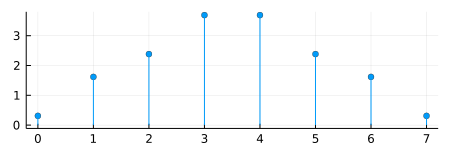

In [6]:
sticks(0:7, real(x_shifted),
    xticks=0:7,
    marker=true,
    size=(450,150)
)

While not overly obvious in the above plot, it is worth noting that the shifts we are doing are circular shifts.  Samples shifted off the end will "wrap around" to the other end of the plot.  This can be seen is we apply a shift of 3 to the input sequence $x$.  First we define a function that performs the shifting operation all in one go, then we use that function to compute $x$ shifted by 3, which clearly shows the circular nature of this shifting operation.  The function is named `fdshift` which is short for "Fourier domain shift".

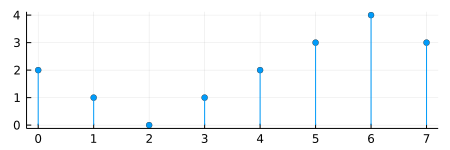

In [7]:
function fdshift(x, s)
    N = length(x)
    k = fftfreq(N,N)

    ifft(fft(x) .* phasor.(k, s, N))
end

let
    xshift3 = real.(fdshift(x, 3))
    
    sticks(0:7, real(xshift3),
        xticks=0:7,
        marker=true,
        size=(450,150)
    )
end

The wrap around effect can be mitigated by either appending zeros to the input
array and doing a longer FFT or just setting the wrapped values to zero.  If the
amount of shifting is small compared to the overall number of samples, it may be
easiest to simply disregard the wrapped values at the edges.